### Imports

In [134]:
import numpy as np
from random import randint
from statistics import median,mean
from pandas import read_csv
import pandas as pd
from PIL import Image, ImageDraw
import random
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.neighbors import NearestNeighbors

### Clause 1 - KNN 

In [135]:
'''
            Clause 1
'''


'Method for calculating the euclidean distance between two points'
def euclidean_distance(point1, point2):
    point1_ = np.array(point1)
    point2_ = np.array(point2)

    # calculating Euclidean distance
    # using linalg.norm()
    dist = np.linalg.norm(point1_ - point2_)

    # return Euclidean distance
    return dist


'Sorting helping method'
def knn_sort_func(list_):
    return list_['distance']


'''
    KNN class contain the the folowing methods:
        - KNN constructor
        - fit() method : to train the algoritm
        - k_neighbors() method : calculate the k neighbors for every input points
'''
class KNN:
    def __init__(self, k):
        self.internal_list = []
        self.k = k

    def fit(self, train_data):
        self.internal_list = train_data

    def k_neighbors(self, new_points):
        neighbors_list = []
        for point in new_points:
            neighbors_list.append(self.point_k_neighbors(point[4:132], point[0:4]))
        return neighbors_list
    
    'Helping method for k_neighbors() method'
    def point_k_neighbors(self, new_point_f, new_point_n):
        point_k_neighbors_list = []
        for point in self.internal_list:
            point_name = point.get('point_name')
            point_features = point.get('point_data')

            dis = euclidean_distance(point_features, new_point_f)
            point_name_dis = {'point_name': new_point_n, 'NN_name': point_name, 'distance': dis}
            point_k_neighbors_list.append(point_name_dis)
        point_k_neighbors_list.sort(key=knn_sort_func)
        return point_k_neighbors_list[:self.k]
    
    def k_neighbors_(self, new_points):    
        neighbors_list = []
        for point in new_points:        
            neighbors_list.append(self.point_k_neighbors_(point[4:]))
        return neighbors_list
    
    'Helping method for k_neighbors_() method'
    def point_k_neighbors_(self, new_point):
        candidates = []
        for tree in self.forest:
            candidates.append(get_neighbors(tree, new_point))   
        return get_final_k_neighbors_(candidates, new_point, self.k)

### Clause 2 - ANN _ KD Tree

In [136]:
'''
            Clause 2
'''


'''
Method that accept list of points and index for 
calculating the median for all the points in this
specific index
'''
def get_median(data, dim):
    data_dim = []
    for point in data:
        data_dim.append(point.get("point_data")[dim])
    return median(data_dim)


'''
Method that accept list of points and index and median 
and return all the points that are bigger or equal to
median in specific dimension 
'''
def get_dim_larger_data(data, dim, med):
    right_data = []
    for point in data:
        if point.get("point_data")[dim] >= med:
            right_data.append(point)
    return right_data


'''
    Method that accept list of points and index and median 
    and return all the points that are smaller to
    median in specific dimension 
'''
def get_dim_smaller_data(data, dim, med):
    right_data = []
    for point in data:
        if point.get("point_data")[dim] < med:
            right_data.append(point)
    return right_data


'''
Method that accept a point and return the neighbors 
for this point by returning the leave that contain 
these neighbors
'''
def get_neighbors(current, point):
    if len(point) == current.point_dim:
        if len(current.data) > current.leave_size:
            if point[current.current_dim % current.point_dim] >= current.current_median:
                return get_neighbors(current.right, point)
            else:
                return get_neighbors(current.left, point)
        else:
            return current.data
    else:
        return


    
'''
    OurKdTree class contain the the folowing methods:
        - OurKdTree constructor
        - build_tree() : builds a random KDtree with the train data
                         that already builded by the constructor, it's a recursive
                         method with limitations of leaves size
'''
class OurKdTree:
    def __init__(self, data, leave_size, point_dim, current_dim):
        self.current_median = 0
        self.current_dim = current_dim
        self.point_dim = point_dim
        self.leave_size = leave_size
        self.left = None
        self.right = None
        self.data = data

    def build_tree(self):
        dim_ = self.current_dim % self.point_dim
        if len(self.data) > self.leave_size:
            median_ = get_median(self.data, dim_)
            self.current_median = median_
            right_data = get_dim_larger_data(self.data, dim_, median_)
            self.right = OurKdTree(right_data, self.leave_size, self.point_dim, self.current_dim + 1)

            left_data = get_dim_smaller_data(self.data, dim_, median_)
            self.left = OurKdTree(left_data, self.leave_size, self.point_dim, self.current_dim + 1)

            if self.leave_size <= len(right_data):
                self.right.build_tree()
            if self.leave_size <= len(left_data):
                self.left.build_tree()
        else:
            return self

'Method to fetch data from file to list'
def get_data(file):
    f_points = []
    data_from_file = read_csv(file)
    points_from_file = data_from_file.values.tolist()
    for point in points_from_file:
        f_points.append({'point_name': point[:4], 'point_data': point[4:]})
    return f_points

'Method returns the dimension of point in data'
def get_point_dim(data):
    if len(data) != 0:
        return len(data[0].get('point_data'))
    return 0


'Sorting helping method'
def my_sort_func(e):
    return e['distance']

'Method that remove all dublicated points'
def remove_dublicates(list_to):
    for i in range(len(list_to) - 1, 0, -1):
        if list_to[i] == list_to[i - 1]:
            del list_to[i]

    return list_to

'Helping method for flattening list of points'
def flat_candidates_list(candidates):
    flat_list = []
    for candidate in candidates:
        for item in candidate:
            flat_list.append(item)
    return flat_list

'''
Method that accepts list of candidates points, from all trees
created, and the method will remove dublicted points then calculate 
the euclidean distance then take the k nearest points and returns 
them as list
'''
def get_final_k_neighbors(candidates, point, k):
    out = flat_candidates_list(candidates)
    res = []
    for candidate in out:
        res.append({'candidate_point': candidate.get('point_name'),
                    'distance': euclidean_distance(candidate.get('point_data'), point)})
    res.sort(key=my_sort_func)
    sorted_list = remove_dublicates(res)
    return sorted_list[0:k]


'''
    ANN class contain the the folowing methods:
        - ANN constructor
        - fit() method : to train the algoritm
        - k_neighbors() method : calculate the k neighbors for every input points
'''
class ANN:
    def __init__(self, N, L, k):
        self.N = N
        self.L = L
        self.k = k
        self.forest = []
        self.data = None

    def fit(self, train_data):
        self.data = train_data
        for tree in range(self.L):
            self.forest.append(OurKdTree(self.data, self.N, get_point_dim(self.data), tree))
        for tree in self.forest:
            tree.build_tree()

    def k_neighbors(self, new_points):
        neighbors_list = []
        for point in new_points:
            neighbors_list.append({'the_point': point[:4], 'k_neighbors': self.point_k_neighbors(point[4:])})
        return neighbors_list

    'Helping method for k_neighbors() method'
    def point_k_neighbors(self, new_point):
        candidates = []
        for tree in self.forest:
            candidates.append(get_neighbors(tree, new_point))
        return get_final_k_neighbors(candidates, new_point, self.k)
    
    def k_neighbors_(self, new_points):    
        neighbors_list = []
        for point in new_points:        
            neighbors_list.append(self.point_k_neighbors_(point[4:]))
        return neighbors_list
    
    'Helping method for k_neighbors_() method'
    def point_k_neighbors_(self, new_point):
        candidates = []
        for tree in self.forest:
            candidates.append(get_neighbors(tree, new_point))   
        return get_final_k_neighbors_(candidates, new_point, self.k)

### Clause 3

In [137]:
'''
            Clause 3
'''


'Sorting helping method'
def ratio_sort_func(e):
    return e['ratio']


'''
Method that accepts data and calculating the ratio for 
every point then collecting the points with ration smaller than 0.8
and return them as a list
'''
def ratio_method(data):
    relevant_points = []
    for point in data:
        ratio = point.get('k_neighbors')[0].get('distance') / point.get('k_neighbors')[1].get('distance')
        if ratio < 0.8:
            relevant_points.append({'the_point': point, 'ratio': ratio})
    relevant_points.sort(key=ratio_sort_func)
    return relevant_points
    # From 913 point in "Hananya2" data, only 68 point have a nearest neighbor
    # in accordance with "Ratio Test".
    # This method creates a new list that contains only these point
    # It prints the relevant point list, and the length of it (amout of points)

'Method that draw points calculated in ratio_method() in the input two images'
def show_10_points(img1, img2, data):
    im_1 = Image.open(img1)
    im_2 = Image.open(img2)
    for point in data:
        color = '#%06X' % randint(0, 0xFFFFFF)
        draw2 = ImageDraw.Draw(im_2)
        x_point2 = point.get('the_point').get('the_point')[1]
        y_point2 = point.get('the_point').get('the_point')[0]
        draw2.ellipse(((x_point2, y_point2), (x_point2 + 8, y_point2 + 8)), fill=color, outline=color)
        draw1 = ImageDraw.Draw(im_1)
        x_point1 = point.get('the_point').get('the_point')[1]
        y_point1 = point.get('the_point').get('the_point')[0]
        draw1.ellipse(((x_point1, y_point1), (x_point1 + 8, y_point1 + 8)), fill=color, outline=color)
    im_2.show()
    im_1.show()

### Clause 4

In [138]:
'''
            Clause 4
'''

'Helping method for calculate_error_rate() method'
def get_ann_result(result, ann_results):
    for ann_result in ann_results:
        if ann_result.get('the_point') == result:
            if len(ann_result.get('k_neighbors')) > 0:
                return ann_result.get('k_neighbors')[0].get('distance')
            else:
                return 0
    return 0

'Helping method for calculate_accuracy() method'
def calculate_error_rate(knn_results, ann_results):
    rate_sum = 0
    for result in knn_results:
        rate_sum = (get_ann_result(result[0].get('point_name'), ann_results) / result[0].get('distance')) + rate_sum
    return ((1 / len(knn_results)) * rate_sum) - 1


'Method that calculate accuracy by running the same data in both algorithms KNN,ANN'
def calculate_accuracy(N, L, train, test):
    knn_obj = KNN(1)

    knn_obj.fit(train)
    knn_results = knn_obj.k_neighbors(test)

    ann_obj = ANN(N, L, 1)
    ann_obj.fit(train)
    ann_results = ann_obj.k_neighbors(test)

    error = calculate_error_rate(knn_results, ann_results)
    return error

'''
Method devide the data to k bulks and for every iteration,
one bulk will considered a test set and the others will consider 
a train set then an accuracy calculation will be done for all these
iterations
'''
def cross_validation(N, L, k, train):
    bulk_size = round(len(train) / k)
    bulk_error_rate = []
    for i in range(0, k):
        bulk_train = train[0: (bulk_size * i)] + train[(bulk_size * i) + bulk_size:]
        bulk_test_dic = train[0 + (bulk_size * i):(bulk_size * i) + bulk_size]
        bulk_test = []
        for value in bulk_test_dic:
            temp = value.get('point_name') + value.get('point_data')
            bulk_test.append(temp)
        bulk_error_rate.append(calculate_accuracy(N, L, bulk_train, bulk_test))
    return mean(bulk_error_rate)

'''
Method that accepts train data and using cross_validation
to calculate accuracy, and returns the best error rate from
the combination of 10 L and 10 N values randomly picked
'''
def grid_search(k, train):
    n_random_list = []
    l_random_list = []
    # Generate random parameters for L,N
    for i in range(0, 10):
        n = random.randint(2, 30)
        n_random_list.append(n)
        n = random.randint(2, 30)
        l_random_list.append(n)
    print('N 10 values (randomly chosen): ', n_random_list)
    print('L 10 values (randomly chosen): ', l_random_list)

    # Find the lowest error rate using cross_validation() method
    lowest_error = {'error_rate': 1, 'N_value': 0, 'L_value': 0}
    for n in n_random_list:
        for l in l_random_list:
            value = cross_validation(n, l, k, train)
            if value < lowest_error.get('error_rate'):
                lowest_error = {'error_rate': value, 'N_value': n, 'L_value': l}
    print('Optimal combination is : ', lowest_error)


### Clause 5

In [139]:
'''
            Clause 5
'''


# Helper method - that returns KNN nearest neighbors - distances only
def get_final_k_neighbors_(candidates, point, k):
    out = flat_candidates_list(candidates)
    res = []
    for candidate in out:
        res.append(euclidean_distance(candidate.get('point_data'), point))
    res.sort()
    sorted_list = remove_dublicates(res)
    return sorted_list[0:k]
    

# method to calculate the speed of ANN with given files, number of test points, ANN params
# this method returns the time taken to proccess the data, uses 'time' library.
def calc_speed_ann(train_file,test_file,num_of_tests,N,L,K):
    
    train_data_ = get_data("Hananya1.csv") # list of the train data
    t0 = time.process_time()  # take time #0
    ann = ANN(N, L, K) # ANN object of given params and K
    ann.fit(train_data_) # fit the ANN object
    test_data = read_csv(test_file) # test data
    test_iloc = test_data.iloc[0:num_of_tests, 0:132] #  iloc to number of points in current text (by given parameter)
    test_points = test_iloc.values.tolist() # test points list 
    ann.k_neighbors_(test_points) # ANN algorithm
    t1 = time.process_time() # take time #1
    return t1-t0 # return time for ANN 

# helper method for sorting list of dicts by speed
def my_func_(list_):
    return list_['speed']


# clause 5 method : returns 5 pairs (L,N) of ANN params that ANN runs fastest, with error < error given as parameter
def five_fastest_param (train_file,test_file,num_of_tests,k):
    
    fastest_params_andspeed = [] # like {params: [L,N], speed: s}
    for i in range (100):
        # get random parameters for ANN
        N = random.randint(1,30)
        L = random.randint(1,30)
        
        # run same training data and test data on both KNN, ANN
        train_data_ = get_data(train_file) 
        knn_obj = KNN(k)
        knn_obj.fit(train_data_)      
        ann_obj = ANN(N, L, k)
        ann_obj.fit(train_data_)
        test_data = read_csv(test_file)
        test_list = test_data.iloc[0:num_of_tests, 0:132]
        test_points = test_list.values.tolist()
        
        knn_res = knn_obj.k_neighbors(test_points) # KNN result
        ann_res = ann_obj.k_neighbors(test_points) # ANN result
        
        
        # check error condition:
        if calculate_error_rate(knn_res, ann_res) < 0.1:
             #  run ANN with L,N (k=3), save params and speed in dict
             params_andspeed = {'params': [N,L], 'speed': calc_speed_ann(train_file,test_file,num_of_tests,N,L,k)}
             # append each dict into fastest_params_andspeed list
             fastest_params_andspeed.append(params_andspeed)

    # sort by speed
    fastest_params_andspeed.sort(key=my_func_)
    # return 5 fastest
    return fastest_params_andspeed[0:5]



# clause 5 - final (+ plt)
def five_fastest_plt (train_file,test_file,num_of_tests,K):
    
    # print five fastest params for given data
    fastest = five_fastest_param (train_file,test_file,num_of_tests,K)
    
    # graph plotting
    params = [] # X = labels
    times = [] # Y = times
    
    # get all parameters (for X), get all times (for Y)
    for i in fastest:
        params.append(i['params'])
        times.append(i['speed'])
    
    # plot 
    y_pos = np.arange(len(params))
    plt.bar(y_pos, times, align='center',alpha=0.5)
    plt.xticks(y_pos,params)
    plt.ylabel('Time')
    plt.xlabel('Params')
    plt.title('5 fastest params in ANN, and time taken')
    plt.show
    
    # print list
    print(fastest)

### Clause 6

In [140]:
'''
            Clause 6
'''


# loop, run ANN  10  times -  with the fastest couple of params by clause 5
# print accuracy and time of each iteration, plot
def ann_tentimes(train_file,test_file,num_of_tests,K):
    
    # run same training data and test data on both KNN, ANN
    train_data_ = get_data(train_file) 
    knn_obj = KNN(K)
    knn_obj.fit(train_data_)      
    ann_obj = ANN(4, 17, K)
    ann_obj.fit(train_data_)
    test_data = read_csv(test_file)
    test_list = test_data.iloc[0:num_of_tests, 0:132]
    test_points = test_list.values.tolist()
        
    knn_res = knn_obj.k_neighbors(test_points) # KNN result
    ann_res = ann_obj.k_neighbors(test_points) # ANN result
    
    # lists - for the plot later
    errors = [] 
    times = []
    
    for i in range (10):
        # fastest parameters from clause 5 : 4,17
        print ("Iteration: " + str(i+1))
        #print(*r, sep="\n")
        print ("Error: " + str(calculate_error_rate(knn_res, ann_res)))
        print ("Time: " + str(calc_speed_ann(train_file,test_file,num_of_tests,4,17,K))+"\n")
        
        errors.append(calculate_error_rate(knn_res, ann_res))
        times.append(calc_speed_ann(train_file,test_file,num_of_tests,4,17,K))
    
    # plot
    plt.plot(errors,times)
    plt.ylabel('Time')
    plt.xlabel('Error')
    plt.show

### Clause 7

In [141]:
'''
            Clause 7
'''

# ANN  implementation using Sklearn (KD Tree)

# read in the data using pandas
train_data = pd.read_csv("Hananya1.csv") #load csv for train data
test_data = pd.read_csv("Hananya2.csv") #load csv for test data

# match train dimension to test dimention
train_data_m = train_data.iloc[0: , 4:132]
test_data_m = test_data.iloc[0:, 4:132]

# training
nn = NearestNeighbors(radius=1.0, algorithm = 'kd_tree',leaf_size=30)
nn.fit(train_data_m)

# testing (for first point in test data (Hananya2.csv))
test = test_data.iloc[0:, 4:132]
#print(nn.kneighbors(test,10))


# Comments:
# first index = the distance from nieghbor
# second index = the index of the nearest neighbor

# accuracy method
def error (train_data,test_data,radius_,leaf_size_):
    nn_kdtree = NearestNeighbors(n_neighbors=2,radius=radius_, algorithm = 'kd_tree',leaf_size=leaf_size_)
    nn_brute = NearestNeighbors(n_neighbors=2, algorithm = 'brute')
    nn_kdtree.fit(train_data)
    nn_brute.fit(train_data)
    
    #results:
    knn_res = nn_brute.kneighbors(test,10)[0][0]
    ann_res = nn_kdtree.kneighbors(test,10)[0][0]
    
    # return error
    return (sum(ann_res)/sum(knn_res))-1 

#print (error (train_data_m,test_data_m,0.5,30))
# output: 0.0 (error 0 = no error)
 
# time method
def timer (train_data,test_data,radius_,leaf_size_):
    t0 = time.process_time()
    nn_kdtree = NearestNeighbors(n_neighbors=2,radius=radius_, algorithm = 'kd_tree' ,leaf_size=leaf_size_)
    nn_kdtree.fit(train_data)
    nn_kdtree.kneighbors(test,5)
    t1 = time.process_time()
    return t1-t0

#print(timer (train_data_m,test_data_m,0.5,30))
# output: 0.125



# Optimisaztion with Grid Search
# Parameters of this model (From :NearestNeighbors API)
# NearestNeighbors(*, n_neighbors=5, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)[source]
# Parameters for grid search : radius, leaf size
radius_arr = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]
leafsize_arr = [10,20,30,40,50,60,70,80,90]
# loop radius_arr, leafsize_arr
def gridSearch_bestParams():
    times = []
    errors = []
    for radius_ in radius_arr:
        for leaf_size_ in leafsize_arr:
            times.append({'time': timer (train_data_m,test_data_m,radius_,leaf_size_), 'radius': radius_ , 'leaf_size' : leaf_size_} )
            errors.append({'error':error (train_data_m,test_data_m,radius_,leaf_size_), 'radius': radius_ , 'leaf_size' : leaf_size_} )
    
    times_sorted = sorted(times, key=lambda k: k['time']) 
    errors_sorted = sorted(errors, key=lambda k: k['error']) 
    
    # you can see the error is always 0 by errors_sorted output
    # therefore, the best parameters will be chosen by time:    
    return  times_sorted[0]

# print(gridSearch_bestParams())   
# output:  {'time': 0.125, 'radius': 0.5, 'leaf_size': 30}

# By clause 6 (code , output below)
# The lowest error was  0.0951163031781872 (same in all iterations)
# The shortest time was  1.09375


# Main

N 10 values (randomly chosen):  [29, 6, 14, 23, 30, 21, 18, 3, 25, 27]
L 10 values (randomly chosen):  [19, 17, 6, 29, 2, 20, 30, 26, 14, 4]
Optimal combination is :  {'error_rate': 0.005924918905271415, 'N_value': 30, 'L_value': 30}
[{'params': [3, 19], 'speed': 0.9960839999994278}, {'params': [4, 18], 'speed': 1.2189470000002984}, {'params': [3, 20], 'speed': 1.3703850000001694}, {'params': [9, 13], 'speed': 1.4389279999995779}, {'params': [5, 20], 'speed': 1.443000000000211}]
Iteration: 1
Error: 0.0951163031781872
Time: 1.1019820000001346

Iteration: 2
Error: 0.0951163031781872
Time: 1.1091010000000097

Iteration: 3
Error: 0.0951163031781872
Time: 1.1430410000002666

Iteration: 4
Error: 0.0951163031781872
Time: 1.1178870000003371

Iteration: 5
Error: 0.0951163031781872
Time: 1.1627699999999095

Iteration: 6
Error: 0.0951163031781872
Time: 1.0728810000000522

Iteration: 7
Error: 0.0951163031781872
Time: 1.14889200000016

Iteration: 8
Error: 0.0951163031781872
Time: 1.089535000000069


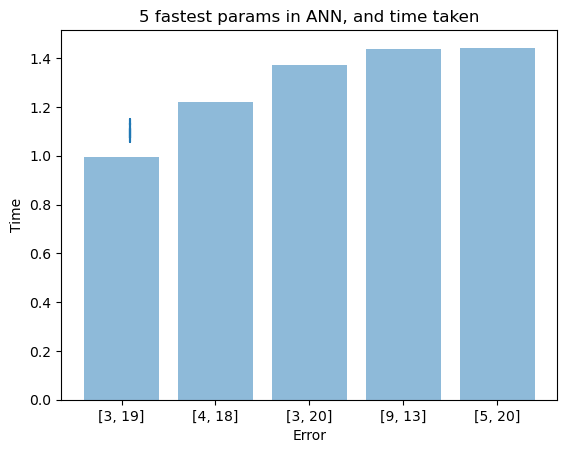

In [142]:
first_file = "Hananya1.csv"
second_file = "Hananya2.csv"
first_image = "Hananya1.JPG"
second_image = "Hananya2.JPG"

train_data_ = get_data(first_file)
nn_data = read_csv(second_file)
data_list = nn_data.iloc[0:, 0:132]
points_to_test = data_list.values.tolist()

'''
The constructor ANN accepts 3 arguments
1-  N: the maximum number of points existed in each leaf in the tree
2-  L: the number of trees created in our forest
3-  k: number of neighbors we need to get for every point 
'''
# Clause 3 - main
p = ANN(10, 20, 2)
p.fit(train_data_)
r = p.k_neighbors(points_to_test)
best_points = ratio_method(r)
show_10_points(first_image, second_image, best_points[:10])

# Clause 4 - main
grid_search(4, train_data_)

# clause 5 - main
five_fastest_plt (first_file,second_file,len(points_to_test),2)   
# output: [{'params': [4, 17], 'speed': 1.15625}, {'params': [6, 14], 'speed': 1.375}, {'params': [11, 12], 'speed': 1.625}, {'params': [7, 15], 'speed': 1.640625}, {'params': [7, 15], 'speed': 1.6875}]


'''
We are getting same error for all 10 runs.
This happens because in the tree building,
the root point median choosing is not happen 
randomly, it's happen iteratively.
'''
# clause 6 - main                                    
ann_tentimes(first_file,second_file,len(points_to_test),2)


# clause 7 - main                                  
print(gridSearch_bestParams())   
